# Fuzzy Logic Analysis for Sensory Data

This notebook demonstrates the application of fuzzy logic to sensory evaluation data. Fuzzy logic is particularly useful in sensory science because consumer perceptions are often subjective and imprecise. Unlike traditional crisp sets where a value either belongs or doesn't belong to a category, fuzzy sets allow for degrees of membership.

## Overview

In this analysis, we will:
1. Use fuzzy logic to model consumer preferences for tortilla chips
2. Create fuzzy membership functions for hedonic ratings (9-point scale) and JAR (Just About Right) ratings (5-point scale)
3. Develop fuzzy inference rules to combine multiple sensory attributes
4. Generate a fuzzy purchase intent index that aggregates flavor liking and saltiness JAR ratings
5. Rank products based on their fuzzy acceptability scores

This approach allows us to handle the inherent uncertainty and vagueness in consumer sensory responses.


## 1. Install Required Packages

First, we need to install the necessary packages. The main package we'll use is `scikit-fuzzy` for fuzzy logic operations.


# Install required packages
%pip install scikit-fuzzy pandas numpy matplotlib openpyxl --quiet


## 2. Import Libraries

Import all necessary libraries for data manipulation, fuzzy logic operations, and visualization.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# Set plotting style
plt.style.use('default')


## 3. Data Loading and Credits

Load the White Corn Tortilla Chips sensory evaluation dataset.


In [4]:
# Load the tortilla chips sensory data
chips = pd.read_excel("data/White Corn Tortilla Chips.xls")

# Display basic information about the dataset
print(f"Dataset shape: {chips.shape}")
print(f"\nColumns: {list(chips.columns)}")
print(f"\nFirst few rows:")
chips.head()


Dataset shape: (879, 9)

Columns: ['Product', 'ProductID', 'panID', 'Liking', 'Appearance', 'Flavor', 'Texture', 'Saltiness JAR', 'PurchaseIntent']

First few rows:


,Product,ProductID,panID,Liking,Appearance,Flavor,Texture,Saltiness JAR,PurchaseIntent
0,P542,BYW,1,8,6,7,7,3,4
1,P225,GMG,1,3,8,3,4,1,1
2,P331,GUY,1,6,4,5,8,2,3
3,P961,MED,1,3,4,2,4,1,1
4,P580,MST,1,9,9,9,9,3,5


### Data Credits

**Dataset:** White Corn Tortilla Chips Sensory Data

**Source:**  
Meullenet, J.-F., Xiong, R., & Findlay, C. J. (2007). *Multivariate and Probabilistic Analyses of Sensory Science Problems*. Ames, IA, USA: Blackwell Press.


## 4. Data Preprocessing

Clean the dataset by removing rows with missing values in key columns needed for fuzzy logic analysis. We require complete data for:
- **Liking**: Overall hedonic rating
- **Flavor**: Flavor liking score
- **Saltiness JAR**: Just-About-Right rating for saltiness
- **PurchaseIntent**: Purchase intent score


In [5]:
# Remove rows with missing values in key columns
initial_count = len(chips)
chips = chips.dropna(subset=["Liking", "Flavor", "Saltiness JAR", "PurchaseIntent"])
final_count = len(chips)

print(f"Initial number of observations: {initial_count}")
print(f"Final number of observations after cleaning: {final_count}")
print(f"Removed: {initial_count - final_count} rows")

# Display summary statistics
print(f"\nSummary statistics for key variables:")
chips[["Flavor", "Saltiness JAR", "PurchaseIntent"]].describe()


Initial number of observations: 879
Final number of observations after cleaning: 879
Removed: 0 rows

Summary statistics for key variables:


,Flavor,Saltiness JAR,PurchaseIntent
count,879,879,879
unique,10,6,6
top,8,3,4
freq,201,423,239


## 5. Fuzzy Logic Setup: Define Universes of Discourse

Before creating fuzzy sets, we need to define the "universes of discourse" (the range of possible values) for each variable:

1. **Hedonic scale (x_hed)**: 9-point scale from 1 to 9
2. **JAR scale (x_jar)**: 5-point scale from 1 to 5  
3. **Purchase Intent index (x_pi)**: Continuous scale from 0 to 10

These universes provide the domain over which our fuzzy membership functions will be defined.


In [6]:
# Define universes of discourse with 0.1 increments for smooth membership functions
x_hed = np.arange(1, 9.1, 0.1)   # 9-point hedonic scale
x_jar = np.arange(1, 5.1, 0.1)   # 5-point JAR scale
x_pi = np.arange(0, 10.1, 0.1)   # Purchase intent index (output)

print(f"Hedonic scale range: {x_hed.min()} to {x_hed.max()}, {len(x_hed)} points")
print(f"JAR scale range: {x_jar.min()} to {x_jar.max()}, {len(x_jar)} points")
print(f"PI index range: {x_pi.min()} to {x_pi.max()}, {len(x_pi)} points")


Hedonic scale range: 1.0 to 9.000000000000007, 81 points
JAR scale range: 1.0 to 5.0000000000000036, 41 points
PI index range: 0.0 to 10.0, 101 points


## 6. Define Fuzzy Membership Functions

Fuzzy membership functions define how much each crisp value belongs to a fuzzy set. We'll create:

### Input Membership Functions:
1. **Hedonic (Flavor Liking)**: Three sets - "dislike", "neutral", "like"
2. **JAR (Saltiness)**: Three sets - "too_weak", "just_right", "too_strong"

### Output Membership Function:
3. **Purchase Intent**: Three sets - "low", "medium", "high" acceptability

We use trapezoidal (`trapmf`) and triangular (`trimf`) membership functions to create smooth transitions between categories.


In [7]:
# Define hedonic membership functions (9-point scale)
# Dislike: low scores (1-4), Neutral: middle scores (3-7), Like: high scores (6-9)
hed_mf = {
    "dislike": fuzz.trapmf(x_hed, [1, 1, 2, 4]),
    "neutral": fuzz.trimf(x_hed, [3, 5, 7]),
    "like":    fuzz.trapmf(x_hed, [6, 8, 9, 9])
}

# Define JAR membership functions (5-point scale)
# Too weak: low scores (1-2.5), Just right: middle scores (2-4), Too strong: high scores (3.5-5)
jar_mf = {
    "too_weak":  fuzz.trapmf(x_jar, [1, 1, 1.5, 2.5]),
    "just_right": fuzz.trimf(x_jar, [2, 3, 4]),
    "too_strong": fuzz.trapmf(x_jar, [3.5, 4.5, 5, 5])
}

# Define output membership functions (Purchase Intent index, 0-10 scale)
# Low: 0-4, Medium: 3-7, High: 6-10
pi_mf = {
    "low":    fuzz.trapmf(x_pi, [0, 0, 2, 4]),
    "medium": fuzz.trimf(x_pi, [3, 5, 7]),
    "high":   fuzz.trapmf(x_pi, [6, 8, 10, 10])
}

print("Fuzzy membership functions created successfully!")

Fuzzy membership functions created successfully!


## 7. Visualize Membership Functions

It's helpful to visualize the membership functions to understand how crisp values map to fuzzy sets. This helps verify that the fuzzy sets appropriately represent the linguistic categories.


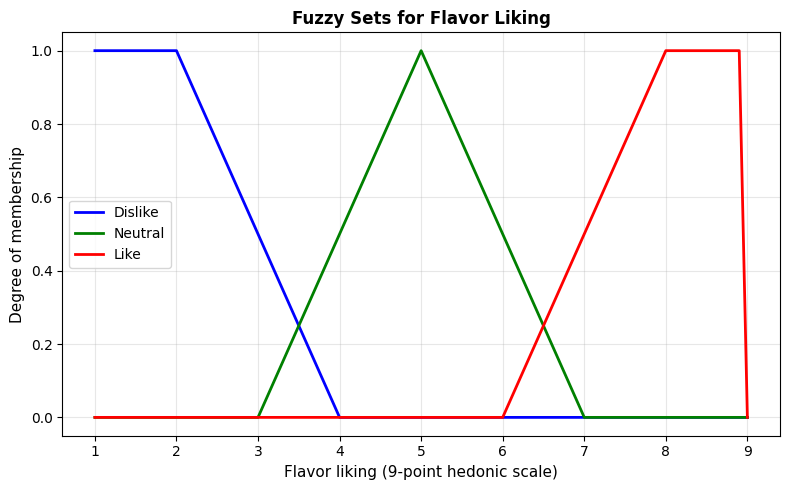

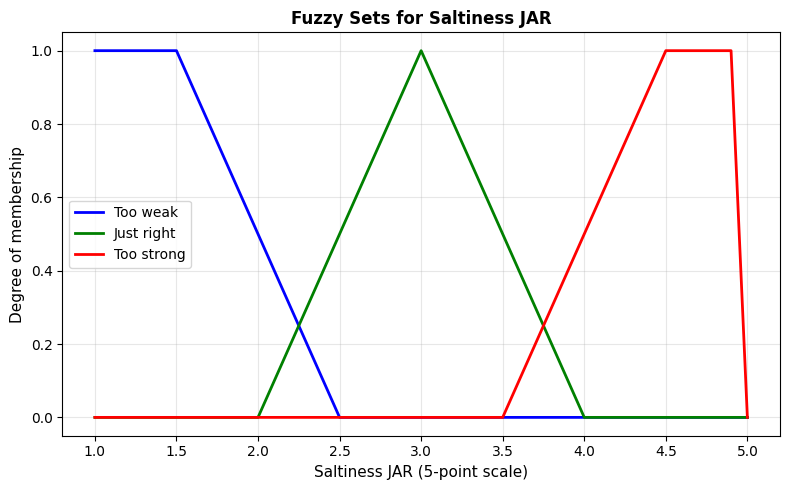

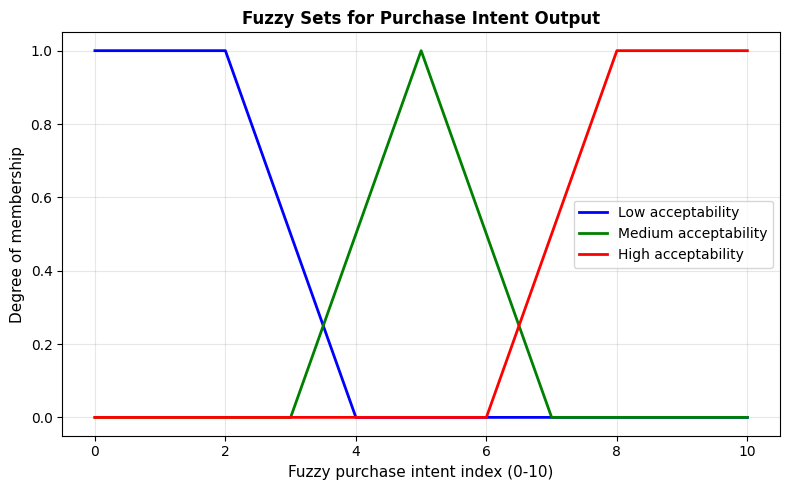

In [8]:
# Visualize hedonic membership functions
plt.figure(figsize=(8, 5))
plt.plot(x_hed, hed_mf["dislike"], 'b-', linewidth=2, label="Dislike")
plt.plot(x_hed, hed_mf["neutral"], 'g-', linewidth=2, label="Neutral")
plt.plot(x_hed, hed_mf["like"], 'r-', linewidth=2, label="Like")
plt.xlabel("Flavor liking (9-point hedonic scale)", fontsize=11)
plt.ylabel("Degree of membership", fontsize=11)
plt.title("Fuzzy Sets for Flavor Liking", fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize JAR membership functions
plt.figure(figsize=(8, 5))
plt.plot(x_jar, jar_mf["too_weak"], 'b-', linewidth=2, label="Too weak")
plt.plot(x_jar, jar_mf["just_right"], 'g-', linewidth=2, label="Just right")
plt.plot(x_jar, jar_mf["too_strong"], 'r-', linewidth=2, label="Too strong")
plt.xlabel("Saltiness JAR (5-point scale)", fontsize=11)
plt.ylabel("Degree of membership", fontsize=11)
plt.title("Fuzzy Sets for Saltiness JAR", fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize output membership functions
plt.figure(figsize=(8, 5))
plt.plot(x_pi, pi_mf["low"], 'b-', linewidth=2, label="Low acceptability")
plt.plot(x_pi, pi_mf["medium"], 'g-', linewidth=2, label="Medium acceptability")
plt.plot(x_pi, pi_mf["high"], 'r-', linewidth=2, label="High acceptability")
plt.xlabel("Fuzzy purchase intent index (0-10)", fontsize=11)
plt.ylabel("Degree of membership", fontsize=11)
plt.title("Fuzzy Sets for Purchase Intent Output", fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Fuzzy Rule Evaluation Function

Now we'll create a function that implements fuzzy inference. The process involves:

1. **Fuzzification**: Convert crisp input values (flavor rating, saltiness JAR) to membership degrees
2. **Rule Evaluation**: Apply fuzzy rules using max-min inference:
   - Rule 1: IF flavor is like AND saltiness is just right → High acceptability
   - Rule 2: IF flavor is neutral AND saltiness is just right → Medium acceptability  
   - Rule 3: IF flavor is dislike OR saltiness is not just right → Low acceptability
3. **Aggregation**: Combine all rule outputs
4. **Defuzzification**: Convert the aggregated fuzzy output to a crisp purchase intent value using centroid method


In [9]:
def safe_float(val):
    """
    Convert value to float, safely handling '.', NaN, or invalid values.
    
    Parameters:
    -----------
    val : any
        Value to convert to float
    
    Returns:
    --------
    float or np.nan
        Converted float value or NaN if conversion fails
    """
    try:
        if pd.isna(val):
            return np.nan
        # Handle string values that might be '.' or empty
        if isinstance(val, str):
            val_stripped = val.strip()
            if val_stripped == '.' or val_stripped == '':
                return np.nan
        return float(val)
    except Exception:
        return np.nan


def eval_rules(flavor, salt_jar):
    """
    Evaluate fuzzy rules to compute purchase intent index.
    
    This function implements a fuzzy inference system with three rules:
    - Rule 1: IF flavor is like AND saltiness is just right → High acceptability
    - Rule 2: IF flavor is neutral AND saltiness is just right → Medium acceptability
    - Rule 3: IF flavor is dislike OR saltiness is not just right → Low acceptability
    
    Parameters:
    -----------
    flavor : float
        Flavor liking score (9-point hedonic scale)
    salt_jar : float
        Saltiness JAR score (5-point scale)
    
    Returns:
    --------
    float
        Fuzzy purchase intent index (0-10), or NaN if inputs are invalid
    """
    # Safely convert input values to floats
    flavor = safe_float(flavor)
    salt_jar = safe_float(salt_jar)
    
    # Return NaN if inputs are invalid
    if pd.isna(flavor) or pd.isna(salt_jar):
        return np.nan
    
    # Step 1: Fuzzification - Convert crisp inputs to membership degrees
    flv_dis = fuzz.interp_membership(x_hed, hed_mf["dislike"], flavor)
    flv_neu = fuzz.interp_membership(x_hed, hed_mf["neutral"], flavor)
    flv_like = fuzz.interp_membership(x_hed, hed_mf["like"], flavor)
    
    s_weak = fuzz.interp_membership(x_jar, jar_mf["too_weak"], salt_jar)
    s_jar = fuzz.interp_membership(x_jar, jar_mf["just_right"], salt_jar)
    s_str = fuzz.interp_membership(x_jar, jar_mf["too_strong"], salt_jar)
    
    # Step 2: Rule evaluation using max-min inference
    # Rule 1: IF flavor like AND salt JAR → high acceptability
    r1 = min(flv_like, s_jar)
    
    # Rule 2: IF flavor neutral AND salt JAR → medium acceptability
    r2 = min(flv_neu, s_jar)
    
    # Rule 3: IF flavor dislike OR salt not JAR → low acceptability
    r3 = max(flv_dis, max(s_weak, s_str))
    
    # Step 3: Aggregate rule outputs on output membership functions
    pi_low = np.fmin(r3, pi_mf["low"])
    pi_med = np.fmin(r2, pi_mf["medium"])
    pi_high = np.fmin(r1, pi_mf["high"])
    
    # Combine all rule outputs using maximum (union)
    aggregated = np.fmax(pi_low, np.fmax(pi_med, pi_high))
    
    # Step 4: Defuzzification - Convert fuzzy output to crisp value using centroid method
    pi_val = fuzz.defuzz(x_pi, aggregated, "centroid")
    return pi_val

print("Fuzzy rule evaluation function created successfully!")


Fuzzy rule evaluation function created successfully!


## 9. Apply Fuzzy Logic to Consumer Data

Apply the fuzzy inference system to each consumer observation in the dataset. This will generate a fuzzy purchase intent index for each product-consumer combination.


In [10]:
# Apply fuzzy rule evaluation to each row in the dataset
chips["PI_fuzzy"] = chips.apply(
    lambda row: eval_rules(row["Flavor"], row["Saltiness JAR"]),
    axis=1
)

# Display results
print(f"Fuzzy purchase intent index calculated for {chips['PI_fuzzy'].notna().sum()} observations")
print(f"\nSummary statistics for fuzzy PI index:")
print(chips["PI_fuzzy"].describe())

print(f"\nSample of results:")
chips[["Product", "Flavor", "Saltiness JAR", "PI_fuzzy"]].head(10)


Fuzzy purchase intent index calculated for 877 observations

Summary statistics for fuzzy PI index:
count    877.000000
mean       4.318748
std        2.987306
min        1.555556
25%        1.761905
50%        1.761905
75%        8.238095
max        8.444444
Name: PI_fuzzy, dtype: float64

Sample of results:


,Product,Flavor,Saltiness JAR,PI_fuzzy
0,P542,7,3,8.238095
1,P225,3,1,1.555556
2,P331,5,2,1.761905
3,P961,2,1,1.555556
4,P580,9,3,8.024895
5,P375,4,1,1.555556
6,P490,4,2,1.761905
7,P305,7,2,1.761905
8,P903,8,3,8.444444
9,P133,6,2,1.761905


## 10. Aggregate Results to Product Level

Aggregate individual consumer fuzzy purchase intent scores to the product level by calculating the mean fuzzy PI index for each product. This provides an overall acceptability ranking of products.


In [12]:
# Aggregate fuzzy PI scores to product level
prod_scores = chips.groupby("Product")["PI_fuzzy"].agg(['mean', 'std', 'count']).reset_index()
prod_scores.columns = ['Product', 'PI_fuzzy_mean', 'PI_fuzzy_std', 'n_observations']
prod_scores = prod_scores.sort_values("PI_fuzzy_mean", ascending=False)

print("Product Rankings by Fuzzy Purchase Intent Index:")
print("=" * 60)
print(prod_scores.to_string(index=False))


Product Rankings by Fuzzy Purchase Intent Index:
Product  PI_fuzzy_mean  PI_fuzzy_std  n_observations
   P325       5.546055      3.029063              80
   P305       5.445518      3.093570              80
   P903       5.338344      3.058666              80
   P375       5.238406      3.052211              80
   P580       4.859380      3.020228              79
   P542       4.337613      2.987629              80
   P133       4.192713      2.904089              80
   P331       3.464398      2.626736              80
   P490       3.395245      2.572661              79
   P225       3.239127      2.531462              79
   P961       2.431151      2.003869              80


## 11. Visualize Product Rankings

Create a bar chart to visualize the fuzzy purchase intent scores for each product, ranked from highest to lowest.


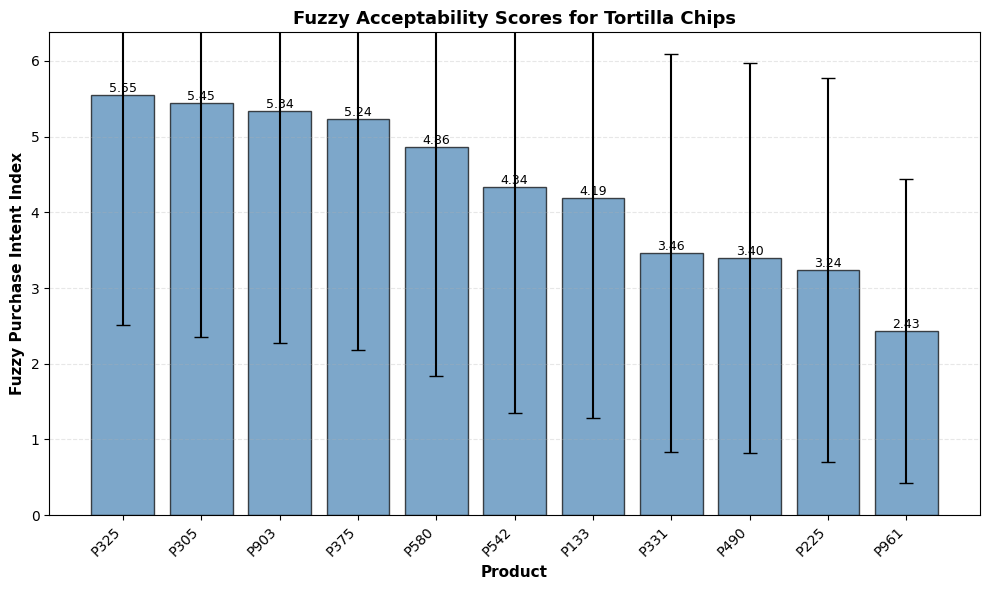

In [13]:
# Create bar chart of product rankings
plt.figure(figsize=(10, 6))
bars = plt.bar(prod_scores["Product"], prod_scores["PI_fuzzy_mean"], 
               color='steelblue', alpha=0.7, edgecolor='black', linewidth=1)

# Add error bars if standard deviation is available
if 'PI_fuzzy_std' in prod_scores.columns:
    plt.errorbar(prod_scores["Product"], prod_scores["PI_fuzzy_mean"], 
                yerr=prod_scores["PI_fuzzy_std"], 
                fmt='none', color='black', capsize=5, capthick=1)

plt.ylabel("Fuzzy Purchase Intent Index", fontsize=11, fontweight='bold')
plt.xlabel("Product", fontsize=11, fontweight='bold')
plt.title("Fuzzy Acceptability Scores for Tortilla Chips", fontsize=13, fontweight='bold')
plt.ylim(0, max(prod_scores["PI_fuzzy_mean"]) * 1.15)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

# Add value labels on top of bars
for i, (bar, val) in enumerate(zip(bars, prod_scores["PI_fuzzy_mean"])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 12. Example: Step-by-Step Fuzzy Inference for a Single Consumer

Let's walk through the fuzzy inference process for a single consumer observation to better understand how the system works. This example demonstrates the complete process from fuzzification to defuzzification.


Example Consumer Inputs:
  Flavor Liking: 6.5 (9-point scale)
  Saltiness JAR: 3.0 (5-point scale)


Fuzzification Results:
  Flavor - Dislike: 0.000, Neutral: 0.250, Like: 0.250
  Saltiness - Too weak: 0.000, Just right: 1.000, Too strong: 0.000

Rule Activation Strengths:
  Rule 1 (like + JAR → high): 0.250
  Rule 2 (neutral + JAR → medium): 0.250
  Rule 3 (dislike OR not JAR → low): 0.000

Final Output:
  Fuzzy Purchase Intent Index: 6.623


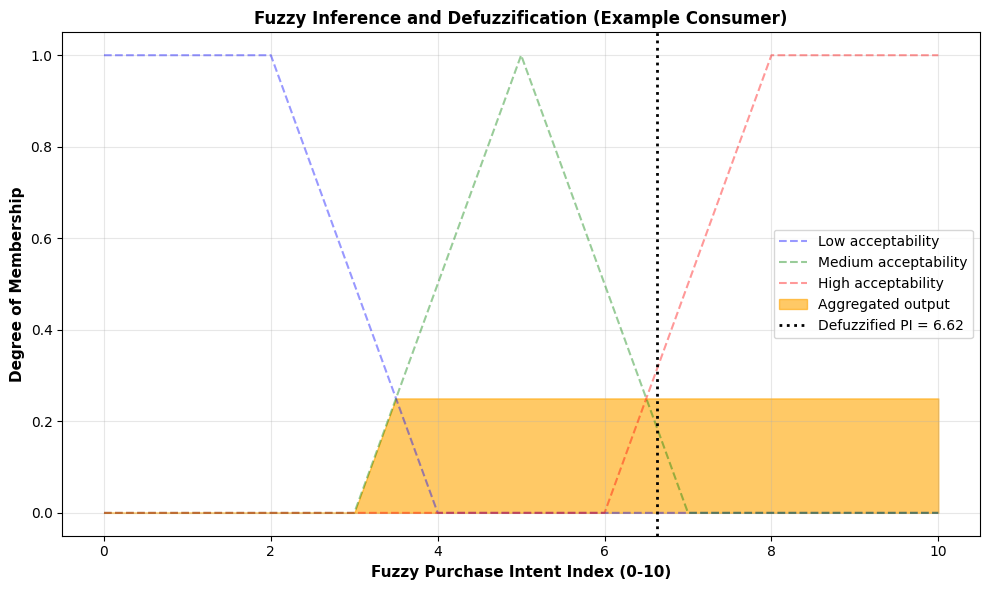

In [14]:
# Example: Single consumer with flavor=6.5 and saltiness JAR=3.0
example_flavor = 6.5
example_salt = 3.0

print(f"Example Consumer Inputs:")
print(f"  Flavor Liking: {example_flavor} (9-point scale)")
print(f"  Saltiness JAR: {example_salt} (5-point scale)")
print("\n" + "="*60)

# Step 1: Fuzzification
flv_dis = fuzz.interp_membership(x_hed, hed_mf["dislike"], example_flavor)
flv_neu = fuzz.interp_membership(x_hed, hed_mf["neutral"], example_flavor)
flv_like = fuzz.interp_membership(x_hed, hed_mf["like"], example_flavor)

s_weak = fuzz.interp_membership(x_jar, jar_mf["too_weak"], example_salt)
s_jar = fuzz.interp_membership(x_jar, jar_mf["just_right"], example_salt)
s_str = fuzz.interp_membership(x_jar, jar_mf["too_strong"], example_salt)

print("\nFuzzification Results:")
print(f"  Flavor - Dislike: {flv_dis:.3f}, Neutral: {flv_neu:.3f}, Like: {flv_like:.3f}")
print(f"  Saltiness - Too weak: {s_weak:.3f}, Just right: {s_jar:.3f}, Too strong: {s_str:.3f}")

# Step 2: Rule Evaluation
r1 = min(flv_like, s_jar)  # IF flavor like AND salt JAR → high
r2 = min(flv_neu, s_jar)   # IF flavor neutral AND salt JAR → medium
r3 = max(flv_dis, max(s_weak, s_str))  # IF flavor dislike OR salt not JAR → low

print(f"\nRule Activation Strengths:")
print(f"  Rule 1 (like + JAR → high): {r1:.3f}")
print(f"  Rule 2 (neutral + JAR → medium): {r2:.3f}")
print(f"  Rule 3 (dislike OR not JAR → low): {r3:.3f}")

# Step 3: Aggregation
pi_low = np.fmin(r3, pi_mf["low"])
pi_med = np.fmin(r2, pi_mf["medium"])
pi_high = np.fmin(r1, pi_mf["high"])
aggregated = np.fmax(pi_low, np.fmax(pi_med, pi_high))

# Step 4: Defuzzification
pi_val = fuzz.defuzz(x_pi, aggregated, "centroid")

print(f"\nFinal Output:")
print(f"  Fuzzy Purchase Intent Index: {pi_val:.3f}")
print("="*60)

# Visualize the inference process
plt.figure(figsize=(10, 6))
# Plot base membership functions (dashed lines)
plt.plot(x_pi, pi_mf["low"], 'b--', alpha=0.4, linewidth=1.5, label="Low acceptability")
plt.plot(x_pi, pi_mf["medium"], 'g--', alpha=0.4, linewidth=1.5, label="Medium acceptability")
plt.plot(x_pi, pi_mf["high"], 'r--', alpha=0.4, linewidth=1.5, label="High acceptability")

# Fill aggregated output
plt.fill_between(x_pi, 0, aggregated, color="orange", alpha=0.6, 
                 label="Aggregated output")

# Mark defuzzified centroid
plt.axvline(pi_val, color="black", linestyle=":", linewidth=2, 
           label=f"Defuzzified PI = {pi_val:.2f}")

plt.xlabel("Fuzzy Purchase Intent Index (0-10)", fontsize=11, fontweight='bold')
plt.ylabel("Degree of Membership", fontsize=11, fontweight='bold')
plt.title("Fuzzy Inference and Defuzzification (Example Consumer)", 
         fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Summary

This notebook demonstrated the application of fuzzy logic to sensory evaluation data. Key points:

1. **Fuzzy logic** allows us to handle uncertainty and imprecision in consumer sensory responses by using degrees of membership rather than crisp categories.

2. **Membership functions** define how sensory scores map to linguistic categories (e.g., "like", "neutral", "dislike").

3. **Fuzzy inference rules** combine multiple sensory attributes (flavor and saltiness) to derive overall acceptability.

4. **Defuzzification** converts fuzzy outputs back to crisp values (purchase intent index) for product ranking.

5. Products can be ranked based on their mean fuzzy purchase intent scores, providing insights into consumer acceptability that account for the inherent vagueness in sensory perception.

### Advantages of Fuzzy Logic in Sensory Analysis:
- Handles subjective and imprecise consumer responses naturally
- Allows for gradual transitions between categories
- Can model complex relationships between multiple attributes
- Provides interpretable results that align with human reasoning

---

**Note:** The fuzzy membership functions and rules used in this analysis can be adjusted based on domain expertise and specific research objectives.
